## Курсовая работа по теме:
## "Построение рекомендательной системы на основе векторного представления графа знаний".

*Выполнила: Подшивалова Анастасия ПМ21-5*

Импортируем необходимые библиотеки:

In [266]:
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import networkx as nx
import random
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from tqdm import tqdm
from gensim.models import Word2Vec
import dgl.nn.pytorch as dglnn
import dgl
from node2vec import Node2Vec
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from sklearn.metrics.pairwise import cosine_similarity

In [267]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [161]:
!pip install node2vec

In [162]:
!pip install gensim

Описание базы данных:\
Структура основана на модели реляционной базы данных с множеством таблиц, которые связаны между собой через первичные и внешние ключи. База данных содержит обширные данные о компаниях, их видах деятельности по ОКВЭД, физических лицах связанных с компаниями, а также товарах и их поставщиках. 


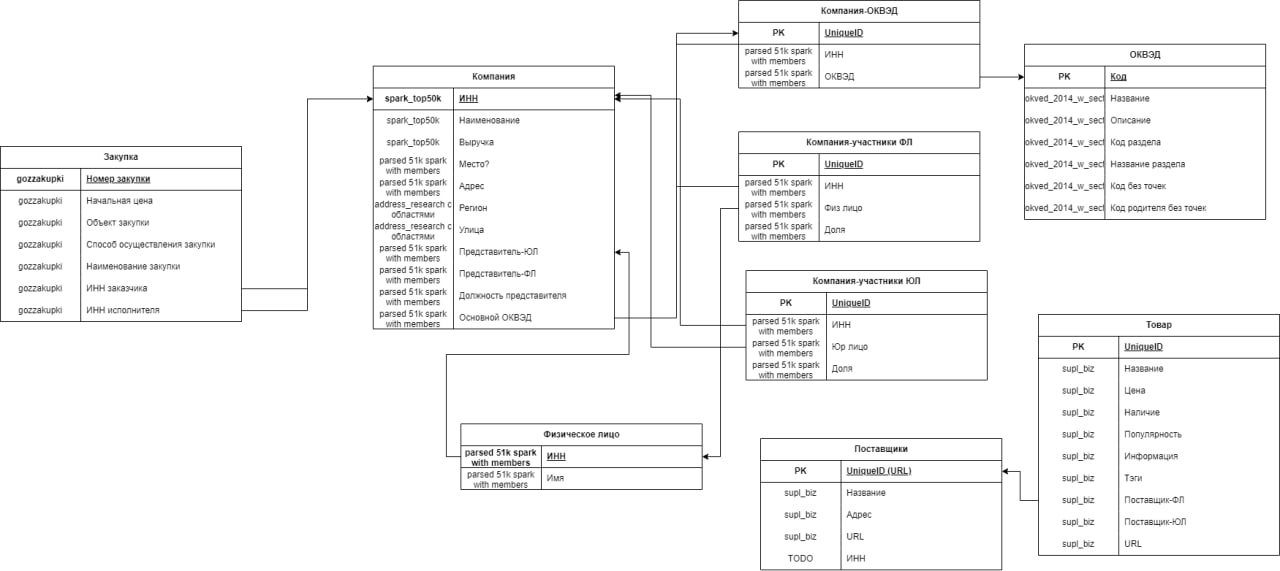

Подключимся к нашей базе данных и создадим курсор для выполнения SQL-запросов.

In [268]:
conn = sqlite3.connect('okved_20230329.sqlite3')

In [269]:
cursor = conn.cursor()

Изучим структуру нашей базы данных:

In [270]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
cursor.execute(query)

tables = cursor.fetchall()

# Вывод списка таблиц, которые содержатся в бд
for table in tables:
    print(table[0])

natural_person
supplier
okved
legal_entity
product
company_to_okved
company_to_natural_member
company_to_legal_member
procurement


In [271]:
# Цикл для обхода каждой таблицы и получения её структуры
for table in tables:
    # Имя таблицы
    table_name = table[0]
    
    column_query = f"PRAGMA table_info({table_name});"
    cursor.execute(column_query)
    
    # Получение списка столбцов
    columns = cursor.fetchall()
    
    print('\033[1m' + f"Таблица: {table_name}" + '\033[0m')
    for column in columns:
        print(f"  {column[1]}") 
    print()

Таблица: natural_person
  inn
  name

Таблица: supplier
  id
  name
  address
  url
  inn

Таблица: okved
  code
  name
  info
  section_code
  section_name
  numeric_code
  parent_numeric_code

Таблица: legal_entity
  inn
  name
  revenue
  location
  address
  region
  street
  post
  natural_representative_inn
  legal_representative_inn
  main_okved_code

Таблица: product
  id
  name
  price
  presence
  is_popular
  info
  tags
  url
  supplier_id

Таблица: company_to_okved
  company_inn
  okved_code

Таблица: company_to_natural_member
  company_inn
  member_inn
  share

Таблица: company_to_legal_member
  company_inn
  member_inn
  share

Таблица: procurement
  id
  start_price
  object
  method
  name
  customer_inn
  executor_inn



Перейдем к созданию графа.
Для этого мы будем использовать несколько таблиц:

In [272]:
# Список таблиц для узлов
nodes_tables = ["legal_entity", "procurement", "natural_person", "okved"]

# Список таблиц для рёбер
edges_tables = ["company_to_natural_member", "company_to_legal_member", "company_to_okved"]

In [273]:
# Создание словаря с именами таблиц и их признаками
table_columns = {}
for table in nodes_tables:
    cursor.execute(f"PRAGMA table_info({table})")
    columns = cursor.fetchall()
    table_columns[table] = [column[1] for column in columns]

df = pd.DataFrame(table_columns.items(), columns=["Table", "Columns"])
pd.set_option('display.max_colwidth', None)

df.style.hide_index()

Table,Columns
legal_entity,"['inn', 'name', 'revenue', 'location', 'address', 'region', 'street', 'post', 'natural_representative_inn', 'legal_representative_inn', 'main_okved_code']"
procurement,"['id', 'start_price', 'object', 'method', 'name', 'customer_inn', 'executor_inn']"
natural_person,"['inn', 'name']"
okved,"['code', 'name', 'info', 'section_code', 'section_name', 'numeric_code', 'parent_numeric_code']"


Создаем пустой граф и добавляем в него узлы.

In [274]:
G = nx.Graph()

# Цикл для обхода каждой таблицы и добавления узлов
for table, columns in table_columns.items():
    data_query = f"SELECT * FROM {table};"
    
    cursor.execute(data_query)
    
    # Получение данных из таблицы
    table_data = cursor.fetchall()
    
    for i, row in enumerate(table_data):
        # Создание уникального имени узла
        node_name = f"{table}_{i}"
        
        # Создание атрибутов узла
        node_attributes = {}
        for j, column_name in enumerate(columns):
            node_attributes[column_name] = row[j]
            
        node_attributes['type'] = table
        
        # Добавление узла в граф
        G.add_node(node_name, **node_attributes)

Каждый узел в графе содержит информацию о записи из таблицы, включая атрибуты соответствующих полей.

In [275]:
list(G.nodes())[:5]

['legal_entity_0',
 'legal_entity_1',
 'legal_entity_2',
 'legal_entity_3',
 'legal_entity_4']

### Сначала связываем узлы графа по атрибутам узлов.

In [276]:
def connect_nodes_by_attribute(graph, source_table, target_table, source_attr, target_attr):
    source_attr_values = {}
    target_attr_values = {}

    # Получаем узлы и их атрибуты для каждой таблицы
    for node, data in graph.nodes(data=True):
        if data.get('type') == source_table:
            source_attr_value = data.get(source_attr)
            source_attr_values.setdefault(source_attr_value, []).append(node)
        elif data.get('type') == target_table:
            target_attr_value = data.get(target_attr)
            target_attr_values.setdefault(target_attr_value, []).append(node)

    # Для каждого значения атрибута из source_table связываем узлы с соответствующими значениями из target_table
    for value, source_nodes in source_attr_values.items():
        if value in target_attr_values:
            target_nodes = target_attr_values[value]
            for source_node in source_nodes:
                for target_node in target_nodes:
                    graph.add_edge(source_node, target_node)

connect_nodes_by_attribute(G, 'legal_entity', 'procurement', 'inn', 'customer_inn')
connect_nodes_by_attribute(G, 'legal_entity', 'procurement', 'inn', 'executor_inn')
connect_nodes_by_attribute(G, 'natural_person', 'legal_entity', 'inn', 'natural_representative_inn')

list(G.edges())[:5]

[('legal_entity_0', 'natural_person_0'),
 ('legal_entity_1', 'procurement_0'),
 ('legal_entity_1', 'procurement_1'),
 ('legal_entity_1', 'procurement_2'),
 ('legal_entity_1', 'natural_person_1')]

In [277]:
len(G.nodes())

166343

Посмотрим общее количество узлов в графе G, которые являются компаниями ('legal_entity') и закупками ('procurement') соответственно.

In [278]:
all_nodes = list(G.nodes())
sum(1 for node in all_nodes if G.nodes[node].get('type') == 'legal_entity')

66818

In [279]:
all_nodes = list(G.nodes())
sum(1 for node in all_nodes if G.nodes[node].get('type') == 'procurement')

24807

### Теперь связываем узлы графа с помощью новых таблиц.

In [280]:
%%time

legal_entity_nodes = {data['inn']: node for node, data in G.nodes(data=True) if data.get('type') == 'legal_entity'}

cursor.execute("SELECT * FROM company_to_legal_member")
company_to_legal_member = cursor.fetchall()

for company_inn, member_inn, share in company_to_legal_member:
    if (company_inn in legal_entity_nodes) and (member_inn in legal_entity_nodes):
        G.add_edge(legal_entity_nodes[company_inn], legal_entity_nodes[member_inn], share=share)

Wall time: 236 ms


Для каждой записи в результатах запроса проверяется, существуют ли узлы в графе для компании и её юридического члена, и если да, то создается ребро между этими узлами с указанием доли владения.

Аналогичную процедуру выполним для связи между компаниями и физическими лицами.

In [281]:
%%time
natural_person_nodes = {data['inn']: node for node, data in G.nodes(data=True) if data.get('type') == 'natural_person'}

cursor.execute("SELECT * FROM company_to_natural_member")
company_to_natural_member = cursor.fetchall()

for company_inn, member_inn, share in company_to_natural_member:
    if (company_inn in legal_entity_nodes) and (member_inn in natural_person_nodes):
        G.add_edge(legal_entity_nodes[company_inn], natural_person_nodes[member_inn], share=share)

Wall time: 400 ms


In [282]:
%%time
okved_nodes = {data['code']: node for node, data in G.nodes(data=True) if data.get('type') == 'okved'}

cursor.execute("SELECT * FROM company_to_okved")
company_to_okved = cursor.fetchall()

for company_inn, okved_code in company_to_okved:
    if (company_inn in legal_entity_nodes) and (okved_code in okved_nodes):
        G.add_edge(legal_entity_nodes[company_inn], okved_nodes[okved_code])

Wall time: 4.07 s


Словарь okved_nodes содержит узлы для кодов ОКВЭД.
Используя данные из таблицы company_to_okved, устанавливаем связи между юридическими лицами и видами их деятельности.

Теперь удалим изолированные узлы из графа.

In [283]:
G.remove_nodes_from(list(nx.isolates(G)))

In [284]:
len(G)

158007

In [285]:
# Просмотр типов атрибутов узлов графа
for node, attrs in list(G.nodes(data=True))[:10]:
    print("Узел:", node)
    print("Типы атрибутов:")
    for attr, value in attrs.items():
        print(f" - {attr}: {type(value)}")

Узел: legal_entity_0
Типы атрибутов:
 - inn: <class 'str'>
 - name: <class 'str'>
 - revenue: <class 'float'>
 - location: <class 'str'>
 - address: <class 'str'>
 - region: <class 'str'>
 - street: <class 'str'>
 - post: <class 'str'>
 - natural_representative_inn: <class 'str'>
 - legal_representative_inn: <class 'NoneType'>
 - main_okved_code: <class 'str'>
 - type: <class 'str'>
Узел: legal_entity_1
Типы атрибутов:
 - inn: <class 'str'>
 - name: <class 'str'>
 - revenue: <class 'float'>
 - location: <class 'str'>
 - address: <class 'str'>
 - region: <class 'str'>
 - street: <class 'str'>
 - post: <class 'str'>
 - natural_representative_inn: <class 'str'>
 - legal_representative_inn: <class 'NoneType'>
 - main_okved_code: <class 'str'>
 - type: <class 'str'>
Узел: legal_entity_2
Типы атрибутов:
 - inn: <class 'str'>
 - name: <class 'str'>
 - revenue: <class 'float'>
 - location: <class 'str'>
 - address: <class 'str'>
 - region: <class 'str'>
 - street: <class 'str'>
 - post: <class

Наш граф получился слишком большим, поэтому для дальнейших манипуляций создадим подграф, который будет повторять структуру исходного графа. Для этого создадим функцию, которая из исходного графа случайным образом выберет один узел и будет наращивать новый граф путем добавления соседей выбранного узла. 

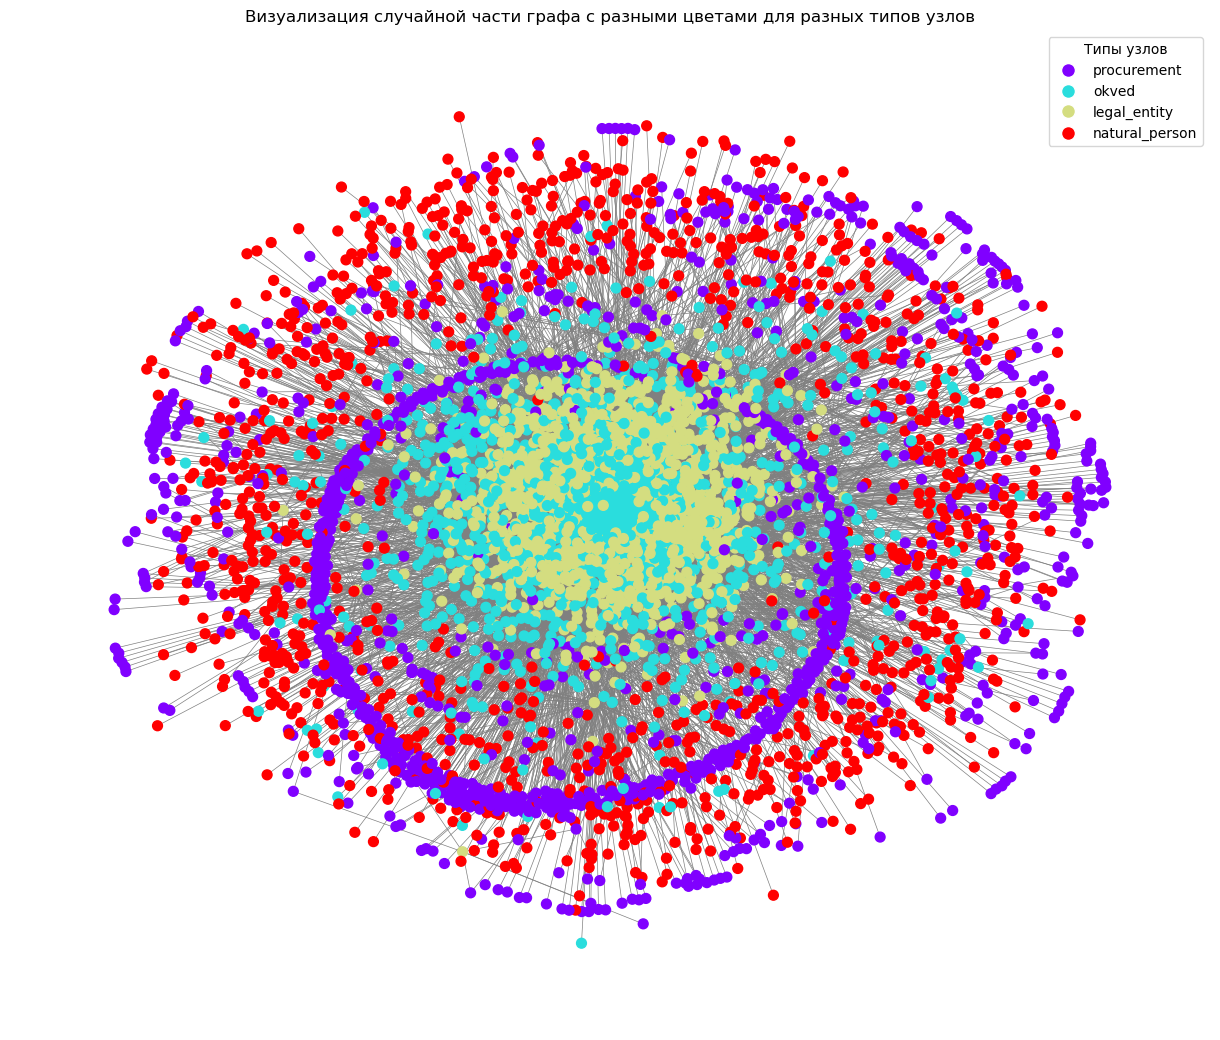

In [286]:
def select_subgraph(graph, initial_node, max_size=5000):
    visualization_nodes = [initial_node]
    checked_nodes = set(visualization_nodes)
    
    # Получаем все типы узлов в графе
    all_types = set(nx.get_node_attributes(graph, 'type').values())
    type_counts = {node_type: 0 for node_type in all_types}

    # Инициализируем счетчик для начального узла
    initial_type = graph.nodes[initial_node]['type']
    type_counts[initial_type] += 1

    while len(visualization_nodes) < max_size and checked_nodes:
        current_node = checked_nodes.pop()
        neighbors = list(graph.neighbors(current_node))
        for neighbor in neighbors:
            neighbor_type = graph.nodes[neighbor]['type']
            if neighbor not in visualization_nodes and type_counts[neighbor_type] < max_size // len(all_types):
                visualization_nodes.append(neighbor)
                checked_nodes.add(neighbor)
                type_counts[neighbor_type] += 1
            if len(visualization_nodes) >= max_size:
                break

    return graph.subgraph(visualization_nodes)

# Выбираем случайный узел из графа
start_node = random.choice(list(G.nodes()))

# Создаем подграф на основе выбранного узла и его соседей
subgraph = select_subgraph(G, start_node)

# Визуализация подграфа с разными цветами для разных типов узлов
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subgraph, k=0.1, iterations=50)

# Получение типов узлов и установка цветов
node_types = nx.get_node_attributes(subgraph, 'type')
unique_types = list(set(node_types.values()))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_types)))
color_map = {node_type: color for node_type, color in zip(unique_types, colors)}

# Раскраска узлов по типу
node_colors = [color_map[node_types[node]] for node in subgraph.nodes()]

nx.draw(subgraph, pos, node_size=50, node_color=node_colors, edge_color='gray', with_labels=False, width=0.5)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[node_type], markersize=10, label=node_type) for node_type in unique_types]
plt.legend(handles=legend_elements, title="Типы узлов", loc='best')

plt.title('Визуализация случайной части графа с разными цветами для разных типов узлов')
plt.show()

Теперь создадим еще одну версию подграфа, которая будет содержать только два типа узлов - компании и закупки.
Сейчас этот граф состоит всего из 1500 узлов для экономии времени, которое затрачивается на обучение моделей. Далее я расширю его.

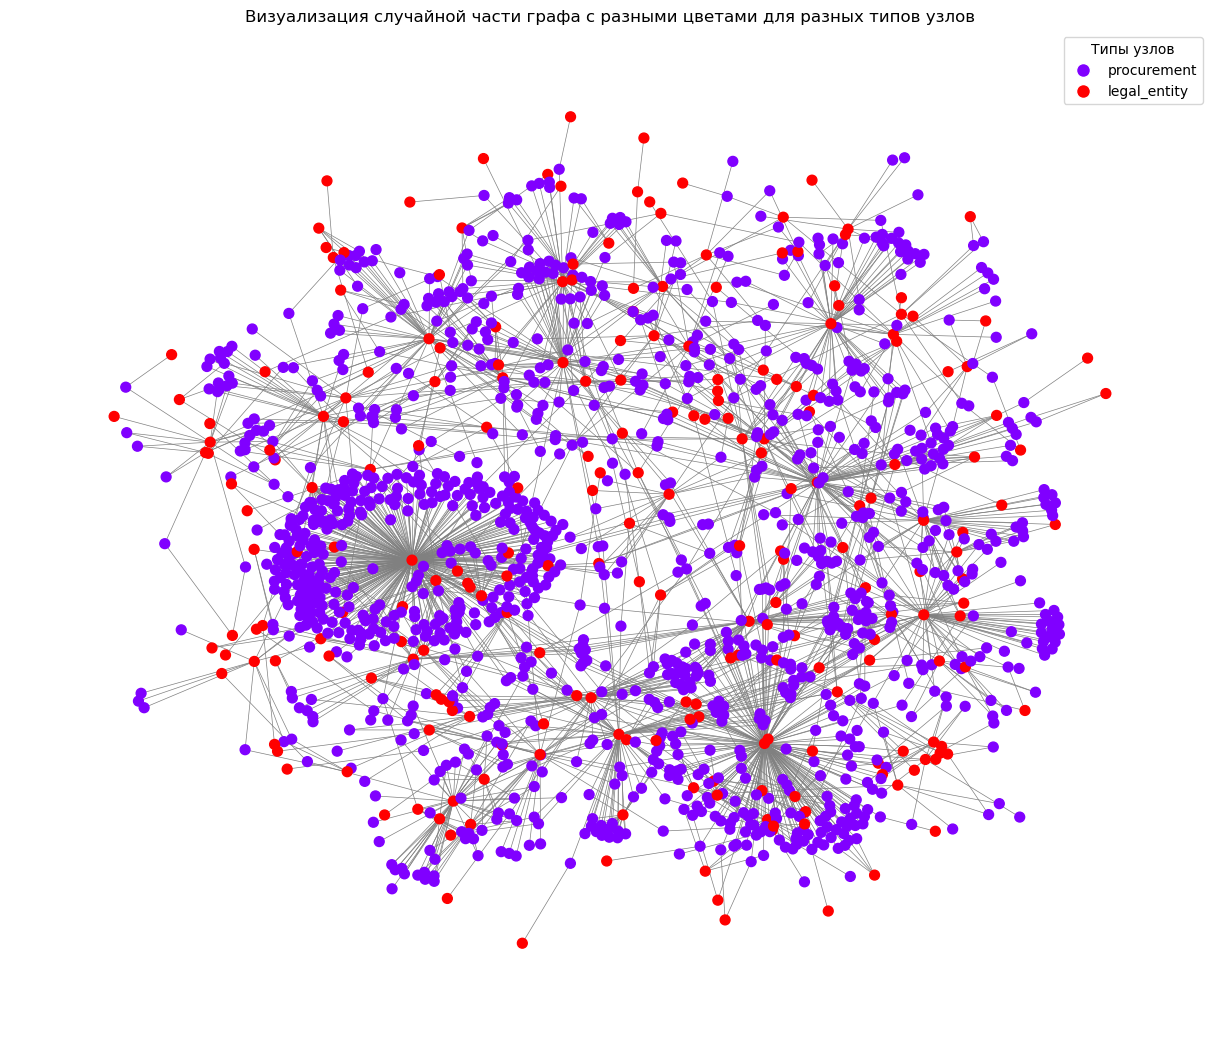

In [287]:
def select_subgraph_snowball(graph, initial_node, allowed_types, max_size=1500):
    visualization_nodes = [initial_node] if graph.nodes[initial_node]['type'] in allowed_types else []
    checked_nodes = set(visualization_nodes)
    all_nodes = list(graph.nodes(data=True))

    while len(visualization_nodes) < max_size and checked_nodes:
        current_node = checked_nodes.pop()
        neighbors = list(graph.neighbors(current_node))
        for neighbor in neighbors:
            if neighbor not in visualization_nodes and graph.nodes[neighbor]['type'] in allowed_types:
                visualization_nodes.append(neighbor)
                checked_nodes.add(neighbor)
            if len(visualization_nodes) >= max_size:
                break

    return graph.subgraph(visualization_nodes)

# Типы узлов, которые мы хотим включить в подграф
allowed_types = ['legal_entity', 'procurement']

# Фильтруем узлы, чтобы выбрать только те, которые соответствуют разрешенным типам
allowed_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') in allowed_types]

# Проверяем, есть ли такие узлы
if allowed_nodes:
    # Выбираем начальный узел с наибольшей степенью
    start_node = max(allowed_nodes, key=lambda node: G.degree(node))

    # Создаем подграф на основе выбранного узла и его соседей
    subgraph = select_subgraph_snowball(G, start_node, allowed_types)

    # Визуализация подграфа с разными цветами для разных типов узлов
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(subgraph, k=0.1, iterations=50)

    # Получение типов узлов и установка цветов
    node_types = nx.get_node_attributes(subgraph, 'type')
    unique_types = list(set(node_types.values()))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_types)))
    color_map = {node_type: color for node_type, color in zip(unique_types, colors)}

    # Раскраска узлов по типу
    node_colors = [color_map[node_types[node]] for node in subgraph.nodes()]

    nx.draw(subgraph, pos, node_size=50, node_color=node_colors, edge_color='gray', with_labels=False, width=0.5)
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[node_type], markersize=10, label=node_type) for node_type in unique_types]
    plt.legend(handles=legend_elements, title="Типы узлов", loc='best')
    plt.title('Визуализация случайной части графа с разными цветами для разных типов узлов')
    plt.show()
else:
    print("В графе нет узлов с разрешенными типами.")

In [288]:
len(subgraph.nodes())

1500

Переходим к векторизации нашего графа. Я представлю несколько вариантов создания векторного представления графа - сначала базовые алгоритмы, а далее более сложные нейронные сети.

1. Node2Vec

In [289]:
node2vec = Node2Vec(subgraph, dimensions=64, walk_length=30, num_walks=200, workers=4) 

# Обучаем модель
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Получаем векторное представление для всех узлов
node_vectors = {node: model.wv[node] for node in subgraph.nodes()}

Computing transition probabilities:   0%|          | 0/1500 [00:00<?, ?it/s]

In [290]:
for key, value in list(node_vectors.items())[:5]:
    print(f"{key}: {value}")

procurement_321: [ 0.1926588   0.00599415 -0.24467863 -0.08807575 -0.7647185  -0.29414827
 -0.02432591  0.06151213 -0.11555206 -0.12993827  0.4320043  -0.5112236
 -0.18395945 -0.5113093  -0.04733939  0.4612127  -0.5081996  -0.13263546
 -0.4109997   0.44320968  0.20970455  0.30321476  0.00730842 -0.22617811
  0.12167677  0.16219051 -0.24907175  0.20324929 -0.3815527   0.16412868
 -0.14752221  0.30576298  0.07092279 -0.5617979   0.0891635  -0.04568028
 -0.16926157  0.03599888 -0.05668438 -0.04835679 -0.68262655  0.08502743
 -0.5145647   0.03151657  0.2905104   0.14592664 -0.21782118  0.57261676
  0.01874096  0.12323075 -0.37233606  0.73184586 -0.11389321  0.01493319
  0.37092355 -0.01498237  0.75850505 -0.42922646 -0.09908698  0.49810562
 -0.41574165  0.08528528 -0.20324776 -0.28340393]
procurement_1086: [ 0.4938959  -0.06268455  0.19382127 -0.27390915 -0.36003405 -0.4726496
  0.2139911  -0.5257052  -0.3480153  -0.6074348  -0.28706235 -0.19724502
  0.18652739 -0.47894874 -0.8029363   0.1

2. Graph Embeddings с помощью DeepWalk

In [291]:
def get_random_walks(graph, num_walks, walk_length):
    walks = []
    for _ in range(num_walks):
        for node in tqdm(graph.nodes(), desc="Generating walks", leave=False):
            walk = [node]
            while len(walk) < walk_length:
                cur = walk[-1]
                next_node = random.choice(list(graph.neighbors(cur)))
                walk.append(next_node)
            walks.append(walk)
    return walks

# Получение случайных обходов
random_walks = get_random_walks(subgraph, num_walks=10, walk_length=30)

# Обучение модели Word2Vec
model = Word2Vec(random_walks, vector_size=64, window=10, min_count=1, sg=1)

In [292]:
# Получение вектора для узла
vector_for_node = {node: model.wv[node] for node in subgraph.nodes()}
for key, value in list(vector_for_node.items())[:5]:
    print(f"{key}: {value}")

procurement_321: [ 0.15752244  0.1975245   0.69845897  0.09987878 -0.5748603   0.10341348
  0.12180416  0.58638114  0.14575788 -0.13422678  0.20847958 -0.68632203
 -0.17430477  0.09921728 -0.4050681  -0.24013807 -0.16349028  0.31215283
 -0.9057914   0.11059162  0.8062567   0.24606751  0.21890095  0.33235857
 -0.21110839 -0.26626962 -0.21198824  0.10052051  0.08242938 -0.18005377
 -0.38008857 -0.26092646  0.09480296 -0.4167363  -0.13462955  0.38330618
 -0.4368836  -0.13588779  0.07025345 -0.29189882 -0.42206332 -0.06390854
 -0.97481364 -0.16581354  0.57682866 -0.12129689  0.16732214 -0.44061774
  0.13379864  0.44835883 -0.43270475  0.24692953 -0.08103962 -0.07040096
  0.29072973  0.37292552 -0.06225072 -0.47103798 -0.390621    0.3443394
 -0.40866104 -0.0299629  -0.3306078  -0.37056562]
procurement_1086: [-0.40202504 -0.00411894  0.18733403  0.20459881 -0.18451732  0.77761954
  0.19210176  0.48703966  0.5955215  -0.11933181  0.47515997 -0.85203093
 -0.64404815  0.09989206 -0.30283263  0.

В этом участке кода мы используем алгоритмы Node2Vec и DeepWalk для создания векторных представлений узлов в графе, где для каждого узла генерируются случайные обходы, которые затем используются для обучения моделей Word2Vec для получения эмбеддингов узлов.

Эти методы не учитывают атрибуты узлов. Они сосредоточены на структуре графа, а именно на последовательностях узлов, появляющихся в случайных обходах.

Также для большого графа эти методы работают очень долго и требуют значительных вычислительных ресурсов.

Поэтому для повышения производительности и эффективности перейдем к реализации графовых нейронных сетей.

3. GCN

GCN работает на принципе совершения "сверток" непосредственно на графах. В контексте графов свертка интерпретируется как агрегирование информации от соседних узлов. 

Для начала подготовим атрибуты узлов графа для использования их в модели GCN.

Начнем процесс с преобразования текстовых данных в числовые с помощью LabelEncoder. Затем для каждого узла создаем вектор признаков, в котором каждый атрибут узла представлен числом, полученным в результате кодирования или преобразования. Эти векторы признаков узлов агрегируем в массив, который затем стандартизируем с помощью StandardScaler. 

In [293]:
def process_node_attributes(subgraph):
    # Определение всех ключей атрибутов, которые встречаются в узлах
    all_keys = set()
    for _, data in subgraph.nodes(data=True):
        all_keys.update(data.keys())

    # Собираем уникальные значения для каждого категориального атрибута
    categorical_data = {key: set() for key in all_keys}
    for node, data in subgraph.nodes(data=True):
        for key in all_keys:
            value = str(data.get(key, 'None'))  # 'None' для отсутствующих значений и преобразование всего в строку
            categorical_data[key].add(value)

    # Обучаем LabelEncoder для каждого категориального атрибута
    encoders = {key: LabelEncoder().fit(list(values)) for key, values in categorical_data.items()}

    features = []
    for _, data in subgraph.nodes(data=True):
        node_features = []
        for key in all_keys:
            value = str(data.get(key, 'None'))  # Преобразование в строку
            if key in encoders:
                # Преобразуем категориальные данные
                encoded_value = encoders[key].transform([value])[0]
                node_features.append(encoded_value)
            else:
                # Преобразуем числовые данные
                node_features.append(float(value))
        features.append(node_features)

    return np.array(features), encoders

# Подготовка данных для модели GCN
features, _ = process_node_attributes(subgraph)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

def create_dgl_graph(subgraph, features):
    node_mapping = {node: i for i, node in enumerate(subgraph.nodes())}
    src, dst = zip(*[(node_mapping[start], node_mapping[end]) for start, end in subgraph.edges()])
    g = dgl.graph((src, dst), num_nodes=len(node_mapping))
    g.ndata['feat'] = torch.tensor(features, dtype=torch.float)
    return g

g = create_dgl_graph(subgraph, scaled_features)
g = dgl.add_self_loop(g)  # Добавляем самопетли

In [294]:
class GCN(torch.nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, h_feats, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(h_feats, num_classes, allow_zero_in_degree=True)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = F.dropout(h, training=self.training, p=0.5)
        h = self.conv2(g, h)
        return h

in_feats = g.ndata['feat'].shape[1]
num_classes = 32
h_feats = 64
lr = 0.01
weight_decay = 0.0001

model = GCN(in_feats, h_feats, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Создание положительных и отрицательных примеров
def create_link_prediction_data(graph, num_neg_samples):
    edges = graph.edges()
    positive_examples = np.array([edges[0].numpy(), edges[1].numpy()], dtype=np.int32)
    all_nodes = list(graph.nodes())
    negative_examples = []

    while len(negative_examples) < num_neg_samples:
        u = random.choice(all_nodes)
        v = random.choice(all_nodes)
        if not graph.has_edges_between(u, v) and u != v:
            negative_examples.append([u, v])

    negative_examples = np.array(negative_examples, dtype=np.int32).T
    return positive_examples, negative_examples

num_neg_samples = len(g.edges()[0])  # Используем столько же отрицательных примеров, сколько и положительных
pos_examples, neg_examples = create_link_prediction_data(g, num_neg_samples)

# Обучение модели
def train():
    model.train()
    optimizer.zero_grad()
    
    # Получаем эмбеддинги узлов
    embeddings = model(g, g.ndata['feat'])
    
    pos_u, pos_v = torch.tensor(pos_examples, dtype=torch.long)
    neg_u, neg_v = torch.tensor(neg_examples, dtype=torch.long)
    
    # Положительные примеры
    pos_scores = torch.sigmoid(torch.sum(embeddings[pos_u] * embeddings[pos_v], dim=1))
    pos_labels = torch.ones(pos_scores.shape[0])

    # Отрицательные примеры
    neg_scores = torch.sigmoid(torch.sum(embeddings[neg_u] * embeddings[neg_v], dim=1))
    neg_labels = torch.zeros(neg_scores.shape[0])

    # Конкатенация и вычисление лосса
    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([pos_labels, neg_labels])
    loss = F.binary_cross_entropy(scores, labels)
    
    loss.backward()
    optimizer.step()
    return loss.item()

# Обучение модели
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

Epoch 0, Loss: 0.7386083006858826
Epoch 10, Loss: 0.4871647357940674
Epoch 20, Loss: 0.4680168330669403
Epoch 30, Loss: 0.458962619304657
Epoch 40, Loss: 0.4549423158168793
Epoch 50, Loss: 0.4424811005592346
Epoch 60, Loss: 0.4413900375366211
Epoch 70, Loss: 0.4409823417663574
Epoch 80, Loss: 0.43592584133148193
Epoch 90, Loss: 0.44041165709495544
Epoch 100, Loss: 0.424745112657547
Epoch 110, Loss: 0.43011894822120667
Epoch 120, Loss: 0.4345363974571228
Epoch 130, Loss: 0.426895409822464
Epoch 140, Loss: 0.43507444858551025
Epoch 150, Loss: 0.4269740581512451
Epoch 160, Loss: 0.42411917448043823
Epoch 170, Loss: 0.4254588782787323
Epoch 180, Loss: 0.4199284613132477
Epoch 190, Loss: 0.4214884340763092


In [295]:
# Получение векторных представлений узлов
model.eval()
with torch.no_grad():
    node_embeddings = model(g, g.ndata['feat'])

print("Векторные представления узлов получены.")
node_embeddings

Векторные представления узлов получены.


tensor([[-0.1267,  0.0897, -0.1031,  ...,  0.1056,  0.2035, -0.3637],
        [ 0.1167,  0.0376,  0.0348,  ...,  0.1667,  0.3200, -0.0518],
        [-0.0629,  0.1268,  0.1090,  ...,  0.0568,  0.0147, -0.2108],
        ...,
        [ 0.0545, -0.0767,  0.0208,  ...,  0.1285, -0.2274,  0.1685],
        [ 0.0621, -0.0357, -0.0088,  ...,  0.0851,  0.0091, -0.0431],
        [-0.2387,  0.0681, -0.0980,  ...,  0.2084, -0.1193,  0.0511]])

Теперь мы имеем векторное представление графа знаний, которое учитывает атрибуты узлов. 

Полученные векторы будут передаваться на вход рекомендательной системе. Реализуем систему для предложения поставщиков заказчикам на основе векторных представлений узлов графа, полученных с помощью модели GCN. Рекомендации будут основаны на косинусном сходстве между векторами заказчиков и поставщиков. 

In [296]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def recommend_suppliers(subgraph, node_embeddings):
    node_mapping = {i: node for i, node in enumerate(subgraph.nodes())}
    reverse_node_mapping = {node: i for i, node in node_mapping.items()}

    customers = [node for node in subgraph.nodes() if subgraph.nodes[node]['type'] == 'procurement']
    suppliers = [node for node in subgraph.nodes() if subgraph.nodes[node]['type'] == 'legal_entity']

    recommendations = []
    ground_truth = []

    for customer in customers:
        customer_index = reverse_node_mapping.get(customer)
        if customer_index is None or customer_index >= len(node_embeddings):
            continue
        customer_embedding = node_embeddings[customer_index].numpy()
        best_supplier = None
        best_similarity = -1

        for supplier in suppliers:
            supplier_index = reverse_node_mapping.get(supplier)
            if supplier_index is None or supplier_index >= len(node_embeddings):
                continue
            supplier_embedding = node_embeddings[supplier_index].numpy()
            similarity = cosine_similarity(customer_embedding, supplier_embedding)

            if similarity > best_similarity:
                best_similarity = similarity
                best_supplier = supplier

        if best_supplier is not None:
            customer_data = subgraph.nodes[customer]
            supplier_data = subgraph.nodes[best_supplier]

            customer_inn = customer_data.get('customer_inn', 'N/A')
            procurement_name = customer_data.get('name', 'N/A')
            supplier_inn = supplier_data.get('inn', 'N/A')

            print(f"\033[1mCustomer INN:\033[0m {customer_inn}, \033[1mProcurement:\033[0m {procurement_name}, \033[1mRecommended Supplier INN:\033[0m {supplier_inn}")
            
            recommendations.append((customer_data.get('customer_inn', 'N/A'), supplier_data.get('inn', 'N/A')))
            ground_truth.append((customer_data.get('customer_inn', 'N/A'), customer_data.get('executor_inn', 'N/A')))

    return recommendations, ground_truth

In [297]:
def evaluate_recommendations(recommendations, ground_truth):
    y_true = [gt[1] for gt in ground_truth]
    y_pred = [rec[1] for rec in recommendations]

    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    return precision, recall, f1

recommendations, ground_truth = recommend_suppliers(subgraph, node_embeddings)

Customer INN: 7734135124, Procurement: Оказание услуги на размещение технологического оборудования на предоставляемых производственных площадях для Челябинского центра ОВД филиала «Аэронавигация Урала» ФГУП «Госкорпорация по ОрВД»., Recommended Supplier INN: 7734135124
Customer INN: 3812014066, Procurement: Поставка продуктов питания и напитков, Recommended Supplier INN: 6905041501
Customer INN: 7734135124, Procurement: Оказание услуг по предоставлению в пользование цифровых каналов связи (г. Хабаровск), Recommended Supplier INN: 7203000249
Customer INN: 2130095159, Procurement: Поставка пудры алюминиевой, Recommended Supplier INN: 2901295280
Customer INN: 6659029556, Procurement: Поставка электрической энергии, Recommended Supplier INN: 6671250899
Customer INN: 5913001162, Procurement: Услуги по поставке газа для котельной №1, Recommended Supplier INN: 6671250899
Customer INN: 3525147496, Procurement: Поставка электрической энергии (Вологда и филиалы), Recommended Supplier INN: 352514

In [1]:
precision, recall, f1 = evaluate_recommendations(recommendations, ground_truth)

print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.498
Recall: 0.5107
F1 Score: 0.5022
